# ERA Timeseries Generation

In [1]:
# Add Heatwave Root to PYTHONPATH
import sys; sys.path.append('../..')

from heatwave import ERA, Country, utils
import netCDF4

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import roc_auc_score
from scipy.ndimage import binary_closing

import calendar
import os

In [2]:
DATA_ROOT = os.path.abspath("../../data")
ERA_ROOT = os.path.join(DATA_ROOT, 'ERA')

# Utility Functions

In [3]:
def summer_indices(df: pd.DataFrame, extra_days: int=0):
    summer_series = []
    for year in np.unique(df.index.year):        
        if calendar.isleap(year):
            summer_series.append(df.loc[f"{23-extra_days}-06-{year}":f"{21+extra_days}-08-{year}"])
        else:
            summer_series.append(df.loc[f"{24-extra_days}-06-{year}":f"{22+extra_days}-08-{year}"])    
    return pd.concat(summer_series).values.ravel()

def plot_T95(T95, year):
    T95_std = T95.mean() + T95.std()

    # Create Big Figure
    plt.rcParams['figure.figsize'] = [15, 5]

    # Plot T95
    plt.title(f"Eastern US Heat Wave Events in Summer of {year}")
    plt.plot(T95[year], c="black", label="T95")
    plt.axhline(T95_std, c="gray", linestyle="--", label="T95 Mean + STD")
    plt.fill_between(T95[year].index, T95_std, T95[year], where=T95[year] > T95_std,
                     interpolate=True, color="crimson", label="Heat Wave Events")

    plt.ylabel("T95 (°C)")
    plt.xlabel("Date")
    plt.xticks(rotation=-90)
    plt.ylim(-3, 3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Create US Country Mask


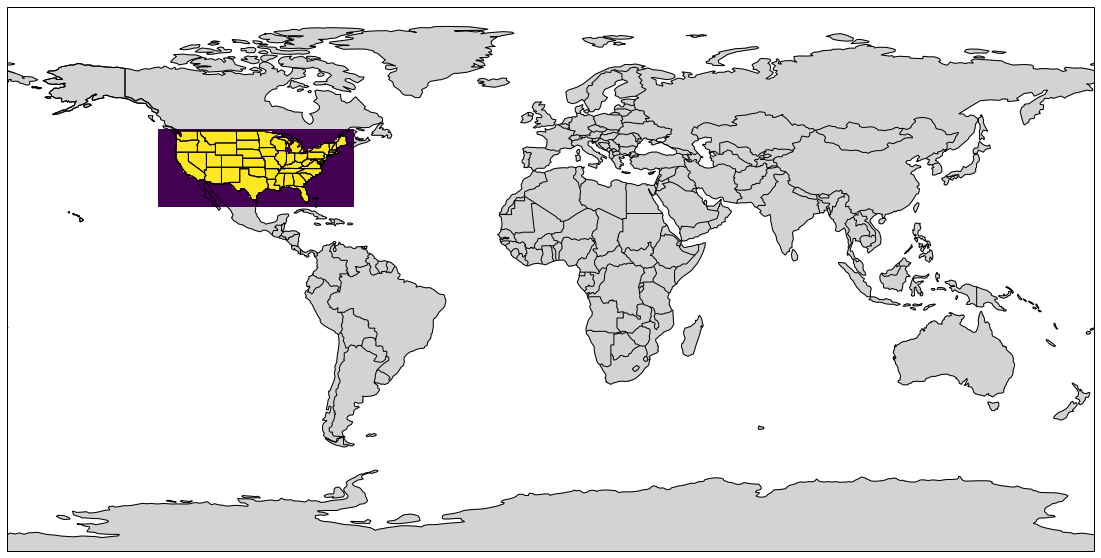

In [4]:
LSM_PATH = os.path.join(ERA_ROOT, 'landseamask_0.75deg.nc')
LSM = ERA(LSM_PATH, 'lsm')

US_LATITUDE_MASK = (LSM.latitude >= 24) * (LSM.latitude <= 50)
US_LONGITUDE_MASK = (LSM.longitude >= 230) * (LSM.longitude <= 295)

US_LATITUDE = LSM.latitude[US_LATITUDE_MASK]
US_LONGITUDE = LSM.longitude[US_LONGITUDE_MASK]

MASK_US = binary_closing(utils.era_country_mask(LSM_PATH) == Country.US) * LSM.data[0].astype(np.bool)

MASK_US = MASK_US[np.nonzero(US_LATITUDE_MASK)[0], :]
MASK_US = MASK_US[:, np.nonzero(US_LONGITUDE_MASK)[0]]

utils.plot_earth()
plt.pcolormesh(US_LONGITUDE, US_LATITUDE, MASK_US)
plt.show()

# Load ERA Temperature at 2 metres (T2M) Data

In [5]:
T2M_PATH = os.path.join(ERA_ROOT, 't2m_1979-2017_1_12_daily_0.75deg.nc')

# Preview T2M Dataset
T2M = ERA(T2M_PATH, 't2m')

# Load T2M Dataset Slice
T2M = ERA(T2M_PATH, 't2m', index=[
    summer_indices(T2M.time, extra_days=3),  # Only Load (Extended) Summer Days
    np.nonzero(US_LATITUDE_MASK)[0],         # Latitude for Mainland US
    np.nonzero(US_LONGITUDE_MASK)[0]         # Longitude for Mainland US
])

# Find Eastern US by Clustering ERA T2M Data based on T95

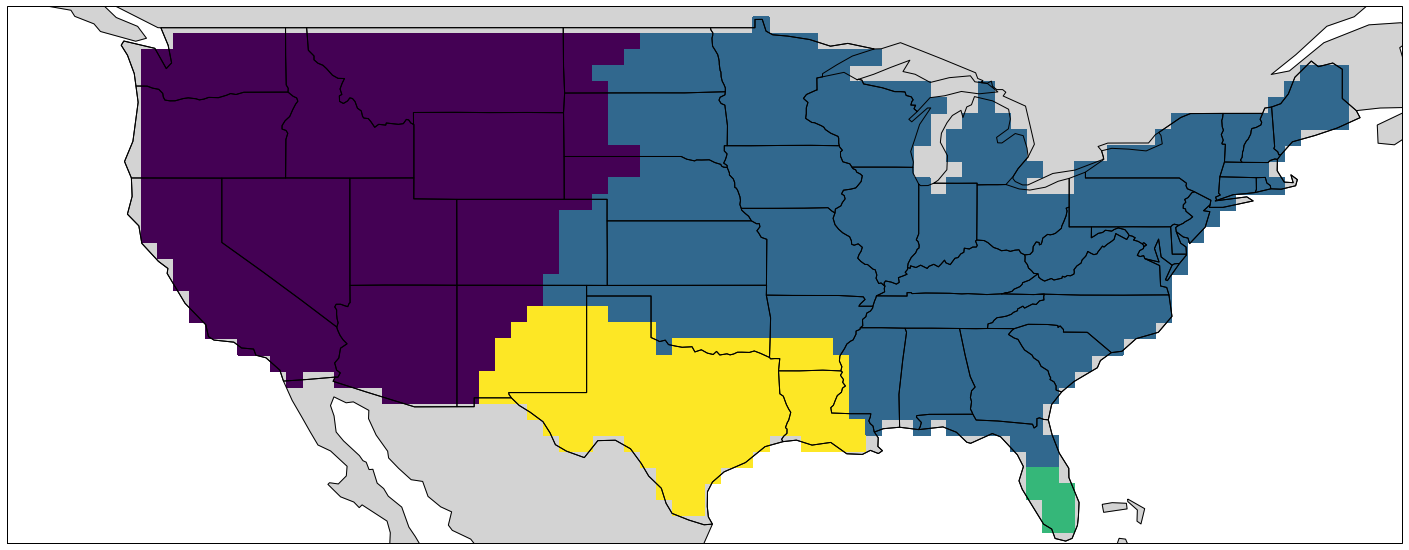

In [6]:
N = 4  # Number of Clusters

T2M_US = T2M.data[:, MASK_US]
T95_BOOL = T2M_US > np.quantile(T2M_US, 0.95, 0)

cluster = AgglomerativeClustering(N, affinity='jaccard', linkage='average')
cluster.fit(T95_BOOL.T)

# Create 2D Label Array
labels = np.empty(T2M.data.shape[1:])
labels.fill(np.nan)
labels[MASK_US] = cluster.labels_

# Identify East US Label,
east_label = np.argmax([np.mean(np.nonzero(labels == i)[1]) if np.sum(labels == i) > 20 else 0 for i in range(N)])
east_mask = labels == east_label
east_latitude = np.mean(np.nonzero(labels == east_label)[0])
east_longitude = np.mean(np.nonzero(labels == east_label)[1])

projection = utils.plot_earth("US")
plt.pcolormesh(US_LONGITUDE, US_LATITUDE, labels)
plt.savefig('cluster.png', dpi=300)
plt.show()

# Calculate T95 Heatwave Timeseries

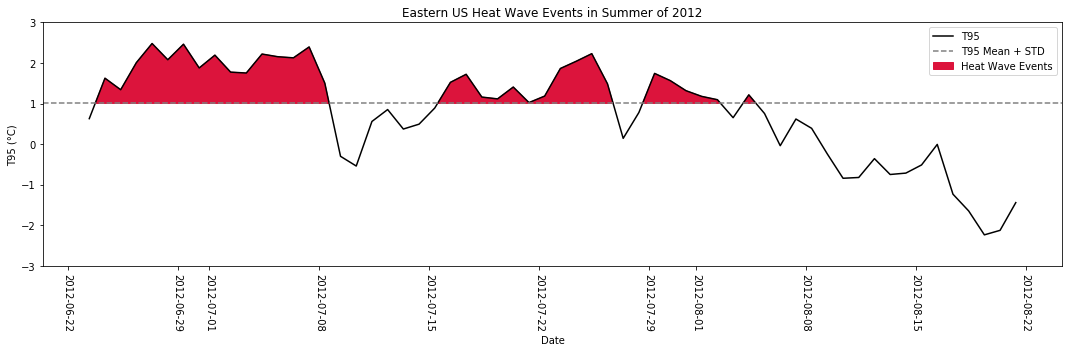

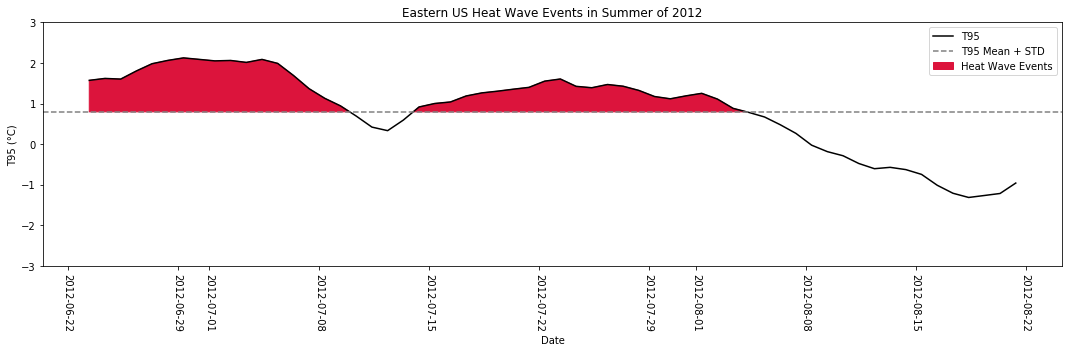

In [7]:
T95 = pd.DataFrame(T2M.anomaly[:, east_mask], index=T2M.time.index).quantile(0.95, 1)

# Normalize T95
T95_norm = (T95 - T95.mean()) / T95.std()

T95_mean = T95_norm.rolling(7, center=True).mean()

summer60 = summer_indices(T2M.time)

T95 = T95[summer60]
T95_norm = T95_norm[summer60]
T95_mean = T95_mean[summer60]

T95_norm.to_csv(os.path.join(DATA_ROOT, 'heatwave.csv'))
T95_mean.to_csv(os.path.join(DATA_ROOT, 'heatwave_mean.csv'))

plot_year = "2012"
plot_T95(T95_norm, plot_year)
plot_T95(T95_mean, plot_year)

# McKinnon Comparison

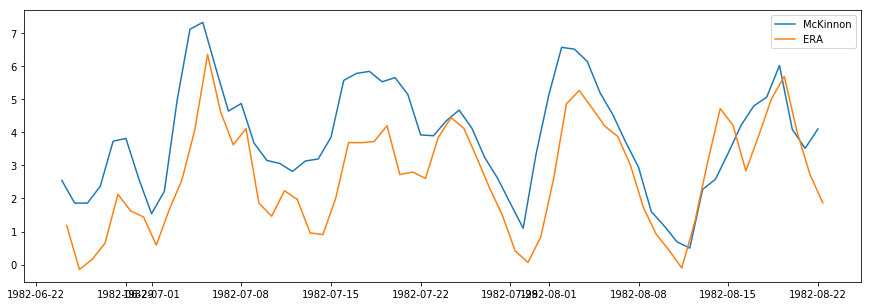

In [8]:
T95_MK = pd.read_csv(os.path.join(DATA_ROOT, 'misc', 'PEP-T95TimeSeries.txt'), sep='\s+')
T95_MK["date"] = pd.to_datetime({'year': T95_MK["Year"], 'month': T95_MK['Month'], 'day': T95_MK['Day']})

T95_MK = T95_MK.set_index("date")
T95_MK = T95_MK.drop(["Year", "Month", "Day"], axis=1)

YEAR = "1982"
plt.plot(T95_MK.loc[T95[YEAR].index - pd.Timedelta(9, 'h')], label="McKinnon")
plt.plot(T95[YEAR], label="ERA")
plt.legend()
plt.show()

In [17]:
T95_LIM = T95["1982":"2015"]
T95_MK_LIM = T95_MK.loc[T95_LIM.index - pd.Timedelta(9, 'h')]

T95_LIM = (T95_LIM - T95_LIM.mean()) / T95_LIM.std()
T95_MK_LIM = (T95_MK_LIM - T95_MK_LIM.mean()) / T95_MK_LIM.std()

MSE = np.mean((T95_LIM.values - T95_MK_LIM.values) ** 2)

CORR = np.corrcoef(T95_LIM.values.ravel(), T95_MK_LIM.values.ravel())[0, 1]

# TODO: Compare Events, not MSE
AUC = roc_auc_score(T95_LIM > 1, T95_MK_LIM)

MSE, CORR, AUC

(1.9990196078431377, 0.9134019035854583, 0.967205135330598)

# Calculate Soil Moisture Timeseries

In [20]:
SM1_PATH = os.path.join(ERA_ROOT, 'sm1_1979-2017_1_12_daily_0.75deg.nc')
SM1 = ERA(SM1_PATH, 'swvl1', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]))

SM2_PATH = os.path.join(ERA_ROOT, 'sm2_1979-2017_1_12_daily_0.75deg.nc')
SM2 = ERA(SM2_PATH, 'swvl2', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]))

SM3_PATH = os.path.join(ERA_ROOT, 'sm3_1979-2017_2jan_31okt_dt-1days_0.75deg.nc')
SM3 = ERA(SM3_PATH, 'swvl3', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]), time_origin='1979-01-02', time_unit='D')

# Soil Moistute Fifth Percentile
SM1_05 = pd.DataFrame(SM1.anomaly[:, east_mask], index=SM1.time.index).quantile(0.05, 1)
SM2_05 = pd.DataFrame(SM2.anomaly[:, east_mask], index=SM2.time.index).quantile(0.05, 1)
SM3_05 = pd.DataFrame(SM3.anomaly[:, east_mask], index=SM3.time.index).quantile(0.05, 1)

SM1_05.to_csv(os.path.join(DATA_ROOT, 'features', 'SM1_05.csv'))
SM2_05.to_csv(os.path.join(DATA_ROOT, 'features', 'SM2_05.csv'))
SM3_05.to_csv(os.path.join(DATA_ROOT, 'features', 'SM3_05.csv'))

# Soil Moisture Mean
SM1_MEAN = pd.DataFrame(SM1.anomaly[:, east_mask], index=SM1.time.index).mean(1)
SM2_MEAN = pd.DataFrame(SM2.anomaly[:, east_mask], index=SM2.time.index).mean(1)
SM3_MEAN = pd.DataFrame(SM3.anomaly[:, east_mask], index=SM3.time.index).mean(1)

SM1_MEAN.to_csv(os.path.join(DATA_ROOT, 'features', 'SM1_MEAN.csv'))
SM2_MEAN.to_csv(os.path.join(DATA_ROOT, 'features', 'SM2_MEAN.csv'))
SM3_MEAN.to_csv(os.path.join(DATA_ROOT, 'features', 'SM3_MEAN.csv'))

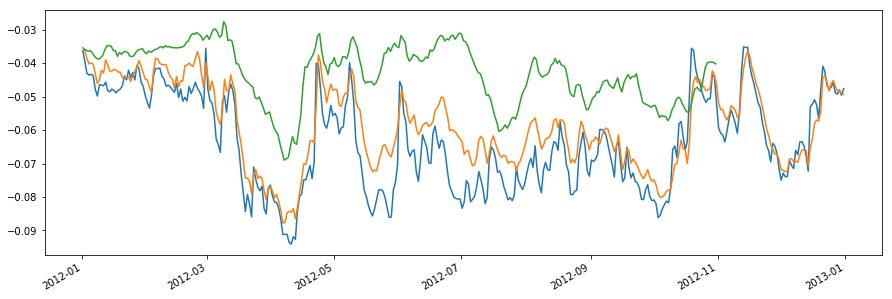

In [11]:
SM1_05["2012"].plot()
SM2_05["2012"].plot()
SM3_05["2012"].plot()
plt.show()

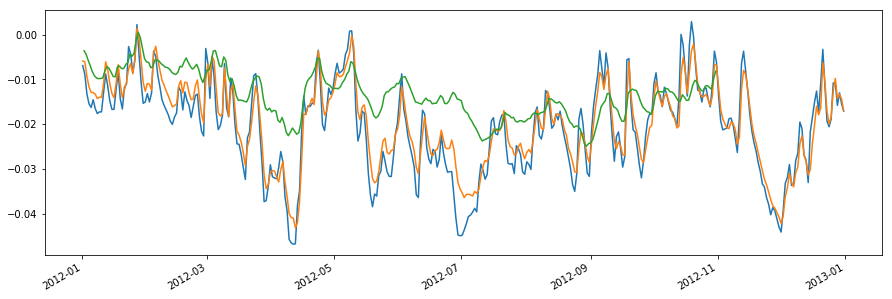

In [19]:
SM1_MEAN["2012"].plot()
SM2_MEAN["2012"].plot()
SM3_MEAN["2012"].plot()
plt.show()

In [12]:
ST1_PATH = os.path.join(ERA_ROOT, 'st1_1979-2017_1mar_31okt_dt-1days_0.75deg.nc')
ST1 = ERA(ST1_PATH, 'stl1', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]), time_origin="1979-03-01", time_unit="D")

ST2_PATH = os.path.join(ERA_ROOT, 'st2_1979-2017_1mar_31okt_dt-1days_0.75deg.nc')
ST2 = ERA(ST2_PATH, 'stl2', index=(None, np.nonzero(US_LATITUDE_MASK)[0], np.nonzero(US_LONGITUDE_MASK)[0]), time_origin="1979-03-01", time_unit="D")

ST1_95 = pd.DataFrame(ST1.anomaly[:, east_mask], index=ST1.time.index).quantile(0.95, 1)
ST2_95 = pd.DataFrame(ST2.anomaly[:, east_mask], index=ST2.time.index).quantile(0.95, 1)

ST1_95.to_csv(os.path.join(DATA_ROOT, 'features', 'ST1_95.csv'))
ST2_95.to_csv(os.path.join(DATA_ROOT, 'features', 'ST2_95.csv'))

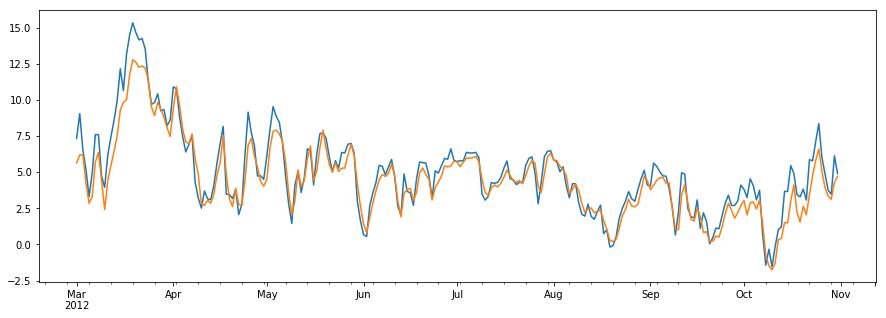

In [13]:
ST1_95["2012"].plot()
ST2_95["2012"].plot()
plt.show()